## CAPSTONE B Intrusion Detection  Packet based  


In [4]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf 
import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize

Using TensorFlow backend.


Preprocessing -Transformation and Scaling 

In [5]:
#tf version
import tensorflow as tf
tf.__version__
#tensorboard version
from tensorboard import version; print(version.VERSION)
#Keras version
import keras 
keras.__version__

'1.14.0'

1.14.0


'2.3.1'

In [6]:
import os
import pandas as pd
os.chdir('C:\\Users\\Brook\\Desktop\\#SMU_Courses\\#MSDS 6130 Capstone A & B\\MSDS6120 CapstoneA\\#ProjectData&NoteBook')

In [7]:
print ( "Current working dir : %s" % os.getcwd())

Current working dir : C:\Users\Brook\Desktop\#SMU_Courses\#MSDS 6130 Capstone A & B\MSDS6120 CapstoneA\#ProjectData&NoteBook


In [8]:
pd.set_option('display.max_columns', None)

In [9]:
train = pd.read_csv(r'UNSW_NB15_training_set.csv')
test = pd.read_csv(r'UNSW_NB15_testing_set.csv')
list_events = pd.read_csv(r'UNSW_NB15_LIST_EVENTS.csv')
features = pd.read_csv(r'UNSW_NB15_features.csv',encoding='latin1')

In [10]:
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

Function to encode string features

In [11]:
le1 = LabelEncoder()
le = LabelEncoder()

vector = combined_data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line 

combined_data['attack_cat'] = le1.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

vector = combined_data['attack_cat']
print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode())
print("mode", len(np.where(vector.values==6)[0])/len(vector),"%")
print("looks like 6 is 'normal', but its not that common")

attack cat: {'Reconnaissance', 'Worms', 'Backdoor', 'Generic', 'Shellcode', 'Normal', 'DoS', 'Exploits', 'Fuzzers', 'Analysis'}

Describing attack_type: 
min 0
max 9
mode 0    6
dtype: int32
mode 0.3609225646458884 %
looks like 6 is 'normal', but its not that common


In [12]:
le1.inverse_transform([0,1,2,3,4,5,6,7,8,9,])

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

???? Dropping thr features of Low Standard deviation and Low corr

In [13]:
##?????
lowSTD = list(combined_data.std().to_frame().nsmallest(6,columns=0).index)
lowCORR = list(combined_data.corr().abs().sort_values('attack_cat')['attack_cat'].nsmallest(3).index) # .where(lambda x: x < 0.005).dropna()
drop = set( lowCORR + lowSTD)
#drop = {'ackdat', 'ct_ftp_cmd', 'djit', 'is_ftp_login', 'is_sm_ips_ports', 'response_body_len', 'sjit', 'synack', 'tcprtt'}
combined_data.shape
combined_data_reduced=combined_data.drop(drop,axis=1)
combined_data_reduced.shape

(257673, 44)

(257673, 35)

In [14]:
pd.set_option('display.max_columns', None)
combined_data_reduced.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,swin,stcpb,dtcpb,dwin,smean,dmean,trans_depth,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,attack_cat,label
0,0.121478,113,0,4,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,255,621772692,2202533631,255,43,43,0,1,0,1,1,1,1,0,1,1,6,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,255,1417884146,3077387971,255,52,1106,0,43,1,1,1,1,2,0,1,6,6,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,255,2116150707,2963114973,255,46,824,0,7,1,2,1,1,3,0,2,6,6,0
3,1.681642,113,3,4,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,255,1107119177,1047442890,255,52,64,0,1,1,2,1,1,3,0,2,1,6,0
4,0.449454,113,0,4,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,255,2436137549,1977154190,255,53,45,0,43,1,2,2,1,40,0,2,39,6,0


In [15]:
lowSTD 

['ackdat', 'synack', 'tcprtt', 'is_ftp_login', 'ct_ftp_cmd', 'is_sm_ips_ports']

In [16]:
#https://stats.stackexchange.com/questions/309612/removing-features-with-low-variance-in-classification-models
lowCORR

['sjit', 'response_body_len', 'djit']

In [17]:
## ??????
transform = list(combined_data_reduced.columns.values[4:])
transform

['spkts',
 'dpkts',
 'sbytes',
 'dbytes',
 'rate',
 'sttl',
 'dttl',
 'sload',
 'dload',
 'sloss',
 'dloss',
 'sinpkt',
 'dinpkt',
 'swin',
 'stcpb',
 'dtcpb',
 'dwin',
 'smean',
 'dmean',
 'trans_depth',
 'ct_srv_src',
 'ct_state_ttl',
 'ct_dst_ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'ct_flw_http_mthd',
 'ct_src_ltm',
 'ct_srv_dst',
 'attack_cat',
 'label']

In [18]:
transform.append('dur')
transform.remove('attack_cat')
# transform min-max norm  only non categorical variables 
combined_data_reduced[transform] = combined_data_reduced[transform].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

Combined data reducd transformation

In [19]:
#combined_data_reduced[transform]

In [20]:
data_x = combined_data_reduced.drop(['attack_cat','label'], axis=1) # droped label
data_y = combined_data_reduced.loc[:,['attack_cat']]

# del combined_data # free mem
# Use stratification to fix imbalance of normal vs. attack categories
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, train_size=0.8,test_size=0.2, random_state = 1, stratify = data_y)

#https://www.bitdegree.org/learn/train-test-split
#X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.70, random_state=42) # TODO

In [21]:
#combined_data_reduced[transform].head(5)

In [22]:
#data_x

In [23]:
#data_y

In [24]:
data_y.isnull().values.any()

False

In [25]:
# is_all_zero = np.all((data_y == 0))
# if is_all_zero:
#     print('Array contains only 0')
# else:
#     print('Array has non-zero items too')


In [26]:
# after we split to 70 /30 to combine dataset

X_train.shape
y_train.shape
X_test.shape # test is larger... good 
y_test.shape

(206138, 33)

(206138, 1)

(51535, 33)

(51535, 1)

Benchmark before additional feature removal

In [27]:
#import xgboost 
#import lightgbm

# DTC = DecisionTreeClassifier()
# RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
# ETC = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)

# Feature selection methods deployed , DTC , RFC , ETC 
DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=25, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_features='auto', bootstrap=False)

#XGB = xgboost.XGBClassifier(n_estimators=150, n_jobs=-1)
#GBM = lightgbm.LGBMClassifier(objective='binary', n_estimators= 500) # multiclass

list_of_CLFs_names = []
list_of_CLFs = [DTC, RFC, ETC]
#list_of_CLFs = [DTC, RFC, ETC, XGB, GBM]
ranking = []

for clf in list_of_CLFs:
    _ = clf.fit(X_train,y_train)
    pred = clf.score(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)

Acc: 0.80883 for the DecisionTreeClassifier
Acc: 0.82953 for the RandomForestClassifier
Acc: 0.82080 for the ExtraTreesClassifier


In [28]:
# mlxtend error fix,https://stackoverflow.com/questions/49889524/issues-importing-mlxtend-python
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from mlxtend.classifier import EnsembleVoteClassifier

https://medium.com/@jonathan_hui/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491

https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/

In [29]:
eclf = EnsembleVoteClassifier

In [30]:

#refe
#https://github.com/alik604/cyber-security/blob/master/Intrusion-Detection/UNSW_NB15.ipynb

#http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/


#eclf = VotingClassifier(clfs=list_of_CLFs, voting='soft')  #refit=False
eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, voting='soft')  #refit=False
_ = eclf.fit(X_train, y_train)
pred = eclf.score(X_test, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))
pred = eclf.predict(X_test)
probas = eclf.predict_proba(X_test)
plt.show()

Acc: 0.82195 for the EnsembleVoteClassifier


In [31]:
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA,TruncatedSVD,PCA
from sklearn.svm import LinearSVC
# Number of trees
n = 10

In [32]:
# rfe = RFE(DecisionTreeClassifier(), n).fit(X_train,y_train)

# desiredIndices = np.where(rfe.support_==True)[0]
# whitelist = X_train.columns.values[desiredIndices]
# X_train_RFE,X_test_RFE = X_train[whitelist],X_test[whitelist]


In [33]:
#Try RFE 

rfe = RFE(DecisionTreeClassifier(), n).fit(X_train, y_train)

desiredIndices = np.where(rfe.support_==True)[0]
whitelist = X_train.columns.values[desiredIndices]
X_train_RFE, X_test_RFE = X_train[whitelist], X_test[whitelist]

print('new shape', X_train_RFE.shape) 

for clf in list_of_CLFs:
    _ = clf.fit(X_train_RFE,y_train)
    pred = clf.score(X_test_RFE,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)


eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, voting='soft')  # refit=False,
_ = eclf.fit(X_train_RFE, y_train)
pred = eclf.score(X_test_RFE, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))


pred = eclf.predict(X_test_RFE)
probas = eclf.predict_proba(X_test_RFE)
plt.show()


new shape (206138, 10)
Acc: 0.80737 for the DecisionTreeClassifier
Acc: 0.82538 for the RandomForestClassifier
Acc: 0.81481 for the ExtraTreesClassifier
Acc: 0.81801 for the EnsembleVoteClassifier


In [34]:
X_train_RFE.head(5)

,dur,sbytes,dbytes,sttl,dinpkt,stcpb,dtcpb,smean,ct_dst_sport_ltm,ct_srv_dst
32951,7.828335e-05,0.000038,0.000021,0.121569,0.000018,0.000000,0.000000,0.079730,0.000000,0.131148
33339,7.601668e-05,0.000101,0.000118,0.121569,0.000005,0.711036,0.711116,0.029054,0.000000,0.065574
111910,5.000001e-08,0.000012,0.000000,0.996078,0.000000,0.000000,0.000000,0.051351,0.066667,0.065574
123747,1.500000e-07,0.000006,0.000000,0.996078,0.000000,0.000000,0.000000,0.022297,0.377778,0.426230
40044,2.915001e-04,0.000106,0.000112,0.121569,0.000017,0.285270,0.286582,0.048649,0.000000,0.163934


In [35]:
## here are the features selected after feature enginnering 

## dur ,sbytes, dbytes,sttl,dinpkt ,stcpb ,dtcpb, smean, ct_dst_sport_ltm, ct_srv_dst

In [36]:
# Try SVD 

svd = TruncatedSVD(n_components=n).fit(X_train)
X_train_svd, X_test_svd = svd.transform(X_train), svd.transform(X_test)

for clf in list_of_CLFs:
    _ = clf.fit(X_train_svd, y_train)
    pred = clf.score(X_test_svd, y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)

eclf = EnsembleVoteClassifier(clfs=list_of_CLFs,  voting='soft') #refit=False,
_ = eclf.fit(X_train_svd, y_train)
pred = eclf.score(X_test_svd, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))


pred = eclf.predict(X_test_svd)
probas = eclf.predict_proba(X_test_svd)
plt.show()

Acc: 0.76115 for the DecisionTreeClassifier
Acc: 0.78438 for the RandomForestClassifier
Acc: 0.77584 for the ExtraTreesClassifier
Acc: 0.77340 for the EnsembleVoteClassifier


In [37]:
svd = TruncatedSVD(n_components=n-1).fit(X_train_RFE)   
X_train_svd, X_test_svd = svd.transform(X_train_RFE), svd.transform(X_test_RFE)

Benchmark after additional feature removal

In [38]:

DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=25, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_features='auto', bootstrap=False)
eclf = VotingClassifier(estimators=[('DecisionTreeClassifier', DTC), ('RandomForestClassifier', RFC),('ExtraTreesClassifier',ETC)], voting='hard')
for clf, label in zip([DTC, RFC,ETC, eclf], ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'Ensemble']): 
        _ = eclf.fit(X_train_svd,y_train)
        pred = eclf.score(X_test_svd,y_test)
        print("Acc: %0.10f [%s]" % (pred,label))

Acc: 0.7911516445 [DecisionTreeClassifier]
Acc: 0.7915979431 [RandomForestClassifier]
Acc: 0.7914233046 [ExtraTreesClassifier]
Acc: 0.7910158145 [Ensemble]


In [39]:
print(X_train_svd.shape)

(206138, 9)


In [40]:
#X_train_svd

#### Deep Learning 

We ran  SVD/PCA to remove variance since the  goal to "get the better deep learning result possible"

In [41]:
from keras.models import Sequential


In [42]:
# ?? why transformation here

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_svd = mms.fit_transform(X_train_svd)
X_test_svd = mms.transform(X_test_svd)

In [43]:
X = X_train_svd
X_t = X_test_svd

dim = X.shape[1]
dim

9

In [44]:
#X

In [45]:
#X_t

In [46]:
#y_test

In [47]:
#THis is for dimensional change for BLSTM RNN
#X_v,y_v  = X_t[:X_t.shape[0]], y_test[:X_t.shape[0]]
#X_v ,y_v = X_t[:X_t.shape[0]/5], y_test[:X_t.shape[0]/5]

In [48]:
#X_v

In [49]:
#y_v

https://keras.io/guides/sequential_model/

The Keras library provides wrapper classes to allow you to use neural network models developed with Keras in scikit-learn.There is a KerasClassifier class in Keras that can be used as an Estimator in scikit-learn, the base type of model in the library. The KerasClassifier takes the name of a function as an argument. This function must return the constructed neural network model, ready for training.
https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
https://forums.fast.ai/t/multiclass-classification-using-dense-layers/216/5
https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

Define The Neural Network Model

In [50]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(18, activation='relu', input_dim=dim))
classifier.add(Dense(36, activation='relu'))
classifier.add(Dropout(0.07))
classifier.add(Dense(18, activation='relu' ))
classifier.add(Dropout(0.07))
classifier.add(Dense(9, activation='relu'))

classifier.add(Dense(10, activation='sigmoid')) # we choose 10 because of 10 categories 

classifier.compile(optimizer ='adam',loss='sparse_categorical_crossentropy', metrics =['accuracy'])

In [51]:
#tensorboard = TensorBoard(histogram_freq=0,write_graph=True)
    
    
tensorboard = TensorBoard(log_dir=f".\logs\MODEL", histogram_freq=1,write_graph=True)

In [52]:
from tensorflow.keras import layers, Sequential

In [53]:
# Data voloume 77301 dataset
# the name tf.summary is deprecated. please use tf.compat.v1.summary instead
# if you get invalid argument error when run the model use 


#tf.reset_default_graph() 
#https://stackoverflow.com/questions/51872592/invalidargumenterror-you-must-feed-a-value-for-placeholder-tensor-placeholder


history = classifier.fit(X,y_train, batch_size=16, epochs=10, validation_data=(X_t,y_test) , callbacks=[tensorboard]).history

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 206138 samples, validate on 51535 samples



Epoch 1/10
206138/206138 [==============================] - 26s 125us/step - loss: 0.9468 - accuracy: 0.6308 - val_loss: 0.7752 - val_accuracy: 0.6857

Epoch 2/10
206138/206138 [==============================] - 25s 121us/step - loss: 0.7361 - accuracy: 0.7169 - val_loss: 0.6887 - val_accuracy: 0.7352
Epoch 3/10
206138/206138 [==============================] - 25s 121us/step - loss: 0.6896 - accuracy: 0.7398 - val_loss: 0.6609 - val_accuracy: 0.7497
Epoch 4/10
206138/206138 [==============================] - 25s 122us/step - loss: 0.6720 - accuracy: 0.7453 - val_loss: 0.6358 - val_accuracy: 0.7581
Epoch 5/10
206138/206138 [==============================] - 25s 121us/step - loss: 0.6601 - accuracy: 0.7503 - val_loss: 0.6374 - val_accuracy: 0.7554
Epoch 6/10
206138/206138 [==============================] - 25s 120us/step - loss: 0.6529 - acc

In [54]:
#pip install keras_sequential_ascii
from keras_sequential_ascii import keras2ascii
keras2ascii(classifier)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           9
               Dense   XXXXX -------------------       180    10.0%
                relu   #####          18
               Dense   XXXXX -------------------       684    38.0%
                relu   #####          36
             Dropout    | || -------------------         0     0.0%
                       #####          36
               Dense   XXXXX -------------------       666    37.0%
                relu   #####          18
             Dropout    | || -------------------         0     0.0%
                       #####          18
               Dense   XXXXX -------------------       171     9.5%
                relu   #####           9
               Dense   XXXXX -------------------       100     5.6%
             sigmoid   #####          10


In [55]:
eval_model=classifier.evaluate(X, y_train )
print(eval_model)


206138/206138 [==============================] - 5s 23us/step
[0.6178700642982282, 0.7645072937011719]


In [56]:
#https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-classification-3a3656c726c1
eval_model=classifier.evaluate(X_t, y_test)
print(eval_model)


51535/51535 [==============================] - 1s 24us/step
[0.6190316219675421, 0.7642185091972351]


In [57]:
#We now predict the output for our test dataset. If the prediction is greater than 0.5 then the output is 1 else the output is 0
y_pred=classifier.predict(X_t)
y_pred =(y_pred>0.5)

https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-classification-3a3656c726c1

In [58]:
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_pred)
# print(cm)

In [59]:
#We now predict the output for our test dataset. If the prediction is greater than 0.5 then the output is 1 else the output is 0
y_pred=classifier.predict(X_t)
#y_pred =(y_pred>0.5) -- this code is good only for binary classification 
#to generate multi class classification 
y_pred = np.argmax(y_pred, axis=1)

In [60]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[    0     0     6   427     3     0    97     2     0     0]
 [    0     0     5   409     4     0     9    39     0     0]
 [    0     0     9  2998    42     1    93   128     0     0]
 [    0     0    11  8125   125     1   303   340     0     0]
 [    0     0    22  1058  1376    11  2127   255     0     0]
 [    0     0     0   287    24 11287   154    22     0     0]
 [    0     0     0   848   830     5 16650   267     0     0]
 [    0     0     0   602    39     5   215  1937     0     0]
 [    0     0     0   133    12     0    26   131     0     0]
 [    0     0     0    29     2     0     1     3     0     0]]


In [61]:
# Finding precision and recall
from sklearn.metrics import precision_score, recall_score
#precision_score(y_test, y_pred)
#recall_score(y_test, y_pred)
#precison for multi class 
precision_score(y_test, y_pred, average='macro')
recall_score(y_test, y_pred, average='macro')

0.37388173651316275

0.37450092274342006

In [62]:
# To compute the F1 score, simply call the f1_score() function:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='macro')

0.3566360318523408

In [63]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       535
           1      0.000     0.000     0.000       466
           2      0.170     0.003     0.005      3271
           3      0.545     0.912     0.682      8905
           4      0.560     0.284     0.377      4849
           5      0.998     0.959     0.978     11774
           6      0.846     0.895     0.870     18600
           7      0.620     0.692     0.654      2798
           8      0.000     0.000     0.000       302
           9      0.000     0.000     0.000        35

    accuracy                          0.764     51535
   macro avg      0.374     0.375     0.357     51535
weighted avg      0.725     0.764     0.727     51535



In [64]:
# plot confusion matrix 


In [65]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20 ,y=1.1)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

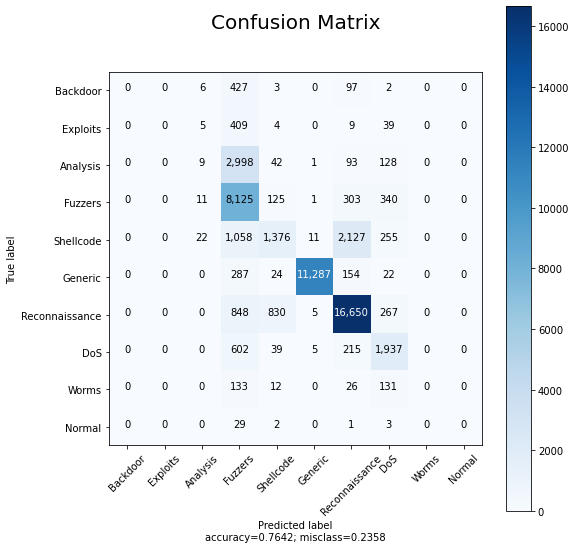

In [66]:
plot_confusion_matrix((cm),
                      normalize    = False,
                      target_names = ['Backdoor', 'Exploits', 'Analysis', 'Fuzzers', 'Shellcode', 'Generic', 'Reconnaissance', 'DoS', 'Worms', 'Normal'],
                      title        = "Confusion Matrix")

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

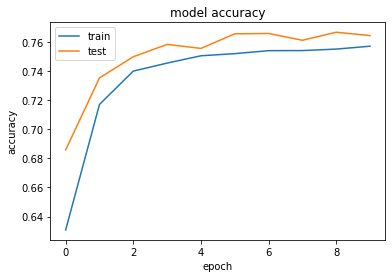

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

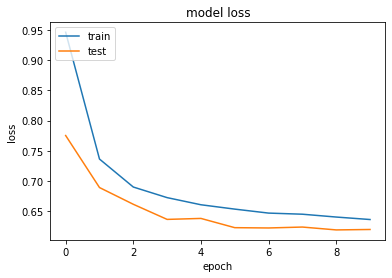

In [67]:
# There is an issue with the test set accuracy plot because it is fluctuating. 
# possible reasons:https://stats.stackexchange.com/questions/189774/oscillating-validation-accuracy-for-a-convolutional-neural-network


# list all data in history
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [68]:
#We now predict the output for our test dataset. If the prediction is greater than 0.5 then the output is 1 else the output is 0
y_pred=classifier.predict(X_t)
#y_pred =(y_pred>0.5) -- this code is good only for binary classification 
#to generate multi class classification 
y_pred = np.argmax(y_pred, axis=1)

In [69]:
#### ??????????????????????????????????/

#from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
#%matplotlib inline

#mnist = fetch_mldata("MNIST original")
#mnist = combined_data_reduced

data_x = combined_data_reduced.drop(['attack_cat','label'], axis=1) # droped label
data_y = combined_data_reduced.loc[:,['attack_cat']]



n_classes = len(set(data_y.attack_cat))

Y = label_binarize(data_y, classes=[*range(n_classes)])

X_train, X_test, y_train, y_test = train_test_split(data_x, Y, train_size=0.8,test_size=0.2, random_state = 1 )


clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=50, max_depth=3, random_state=0))

clf.fit(X_train, y_train) 
print(clf.score(X_test, y_test))

clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)
#y_score = clf.predict(X_test)


OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=3,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=50,
                                                     n_jobs=None,
                                                  

0.5268846415057727


OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=3,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=50,
                                                     n_jobs=None,
                                                  

Text(0.5, 0, 'recall')

Text(0, 0.5, 'precision')

Text(0.5, 1.0, 'precision vs. recall curve')

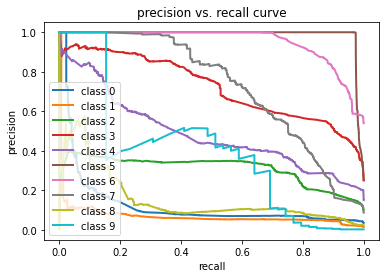

In [70]:
y_score = clf.predict_proba(X_test)

# precision recall curve
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

Text(0.5, 0, 'false positive rate')

Text(0, 0.5, 'true positive rate')

Text(0.5, 1.0, 'ROC curve')

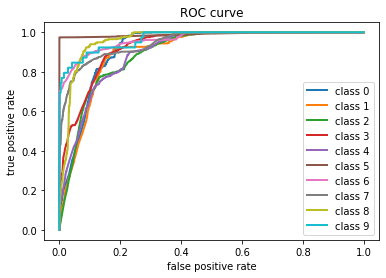

In [71]:
y_score = clf.predict_proba(X_test)

# roc curve
fpr = dict()
tpr = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  y_score[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

In [78]:
#https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal


FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

ACC

FNR

FN

array([0.98961871, 0.9909576 , 0.93584942, 0.85309013, 0.91163287,
       0.99010381, 0.90346367, 0.96026002, 0.9941399 , 0.99932085])

array([1.        , 1.        , 0.99724855, 0.08759124, 0.71623015,
       0.04136232, 0.10483871, 0.3077198 , 1.        , 1.        ])

array([ 535,  466, 3262,  780, 3473,  487, 1950,  861,  302,   35],
      dtype=int64)

In [ ]:

# model metrics summary 

# TPR, Recall, Sensitivity = TP / (TP + FN)

# False positive rate (FPR),Fall-out, probability of false alarm = FP/(FP+TN) type II errror 

# False negative rate (FNR), Miss rate = FN/(TP+FN)  type I error 

# Specificity, Selectivity, True negative rate (TNR) = TN / (FP + TN)

# Prevalence = (TP+FN)/Total_Population

# Positive predictive value (PPV), Precision = TP / (TP + FP)

# False omission rate (FOR) = FN / (FN + TN)

# Positive likelihood ratio (LR+) = TPR/FPR

# Negative likelihood ratio (LR−)= FNR/TNR

# Accuracy (ACC) = (TP+TN)/Total_Population

# False discovery rate (FDR) = FP/(TP+FP)

# Negative predictive value (NPV)= TN / (FN + TN)

# Diagnostic odds ratio (DOR) = LR+/LR−

# F1 score = 2 · Precision · Recall/Precision + Recall

